# Relative Vorticity

This notebook shows a simple example of calculation the surface relative vorticity,

$$\zeta = \partial_x v - \partial_y u$$

**Requirements:** The `conda/analysis3-20.01` (or later) module on the VDI/gadi (or your own up-to-date cookbook installation).

**Firstly,** load in the requisite libraries:

In [11]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
from dask.distributed import Client

import matplotlib
from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
rc('text', usetex=False)

import xgcm
print("xgcm version ", xgcm.__version__)

xgcm version  0.3.0


Load a `dask` client.

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:42119 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 48 Memory: 202.49 GB


In [3]:
expt = '025deg_jra55v13_iaf_gmredi6'
session = cc.database.create_session()

Various parameters that will be used for computing quantities.

In [4]:
day = 24*60*60 # a day in seconds
Ω = 2*np.pi/day # Earth's rotation rate in radians/s
Rearth = 6400*1e3 # Earth's radius in m

Load `lon` and `lat` used in the experiment. These datasets can be used for 

In [5]:
lon = cc.querying.getvar(expt, 'geolon_c', session, ncfile="ocean_grid.nc", n=1)
lat = cc.querying.getvar(expt, 'geolat_c', session, ncfile="ocean_grid.nc", n=1)

Calculate the Coriolis parameter $f = 2\Omega \sin(\theta)$, where $\theta$ is latitude.

In [6]:
f = 2*Ω*np.sin(lat*np.pi/180)
f = f.rename('Coriolis')
f.attrs['long_name'] = 'Coriolis parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'

Load the $u$ and $v$ velocity snapshots. Then we pick a depth value below the Ekman layer, namely the closest to $z=-30\,m$.

The code `.isel(time=-1)` selects the final snapshot of `u` or `v`. Remove `.isel(time=-1)` to load **all** available snapshots of the flow fields.

In [7]:
depth = 30 #m; avoid the surface Ekman layer by taking the "surface values" at some depth close to the surface

u = cc.querying.getvar(expt, 'u', session, ncfile="ocean.nc")
u = u.isel(time=-1).sel(st_ocean=depth, method='nearest')

v = cc.querying.getvar(expt, 'v', session, ncfile="ocean.nc")
v = v.isel(time=-1).sel(st_ocean=depth, method='nearest')

Compute relative vorticity $\zeta = \partial_x v - \partial_y u$. Note that we need to take into account that the $u$ and $v$ coordinates were in degrees and, therefore, we need to divide by $R_{\rm Earth}*\pi/180$ to convert $\partial_x$ and $\partial_y$ to units of $m^{-1}$.

(Note the unicode characters like ζ can be used in `python`.)

In [95]:
ζ = v.differentiate('xu_ocean')/(np.pi/180*Rearth) - u.differentiate('yu_ocean')/(np.pi/180*Rearth*np.cos(lat*np.pi/180))
ζ = ζ.rename('Relative Vorticity')
ζ.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
ζ.attrs['units'] = 's-1'

In [96]:
ζ

<xarray.DataArray 'Relative Vorticity' (yu_ocean: 1080, xu_ocean: 1440)>
dask.array<sub, shape=(1080, 1440), dtype=float32, chunksize=(216, 288), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
    st_ocean  float64 30.36
    time      object 2257-06-30 12:00:00
    geolon_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
Attributes:
    long_name:  Relative Vorticity, ∂v/∂x-∂u/∂y
    units:      s-1

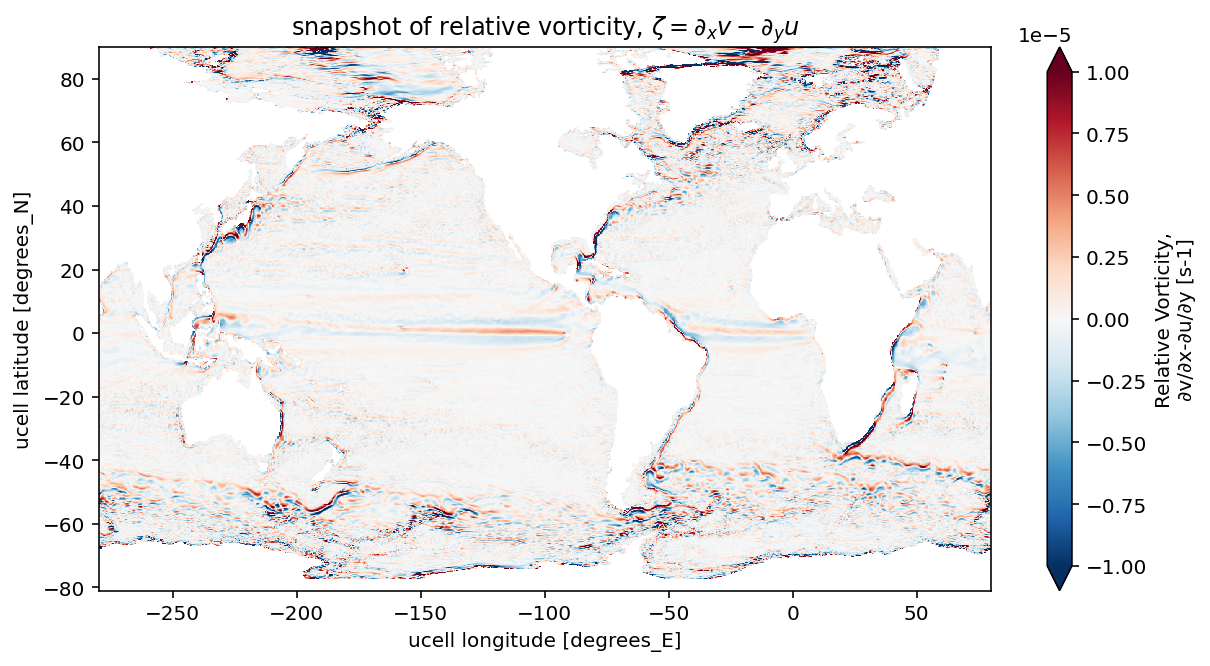

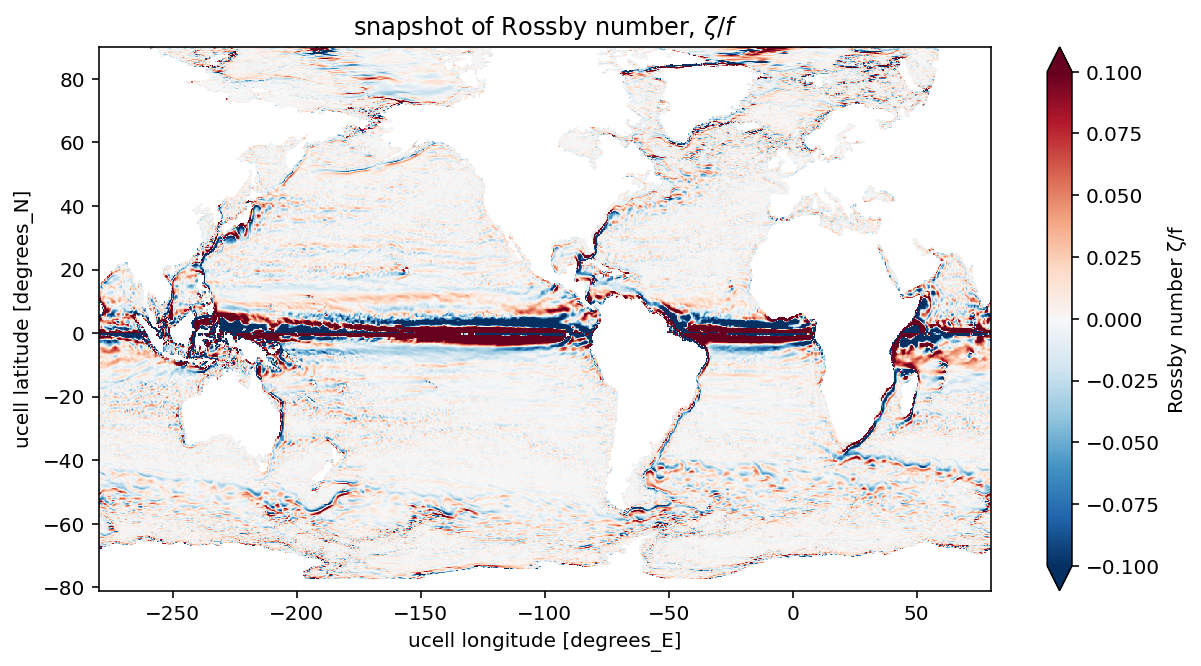

In [98]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ζ.plot(cmap="RdBu_r", vmin=-1e-5, vmax=1e-5, ax=ax)
ax.set_title("snapshot of relative vorticity, $\zeta = \partial_x v - \partial_y u$");

Ro = ζ/f
Ro = Ro.rename('Rossby number ζ/f')

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
Ro.plot(cmap="RdBu_r", vmin=-0.1, vmax=0.1, ax=ax)
ax.set_title("snapshot of Rossby number, $\zeta/f$");